In [182]:
import numpy as np
from scipy.optimize import fsolve
from numpy.linalg import eig
import matplotlib.pyplot as plt
from tqdm import tqdm

def glv(X, A, r):
    return X * (r + A @ X)

def glv_holland_ii(X, r, n, h, fa, fm, A, mutualisms, antagonisms):
    """
    Calculate the population derivatives for a Holland type II functional response.
    """
    a = generate_holland_matrix_cascade(X, n, h, fa, fm, A, mutualisms, antagonisms)
    return X * (r + A @ X)

def generate_glv_matrix_cascade(N, A, fA, fM, P=0.1, pM=0):
    """
    Parameters:
        N: number of species
        fA: relative strength of antagonistic interactions
            any positive number?
        fM: relative strength of mutualistic interactions
            any positive number?
        P: density of interaction matrix
            float in [0, 1]
        pM: probability of mutualistic interactions, within those P interactions
            float in [0, 1]
    Return:
        a: the actual interaction matrix
            (N x N) matrix
    """
    e = np.random.uniform(0, 1, (N, N)) # mutualistic interaction efficiencies
    g = np.random.uniform(0, 1, (N, N)) # antagonistic interaction efficiencies
    A = np.random.uniform(0, 1, (N, N)) # potential interaction preferences
    np.fill_diagonal(A, 0)
    
    a = np.zeros((N, N))
    n_a = int(P * N * (N - 1) / 2)
    
    # Construct list of all pairs of species
    pairs = np.array([(i, j) for i in range(n) for j in range(i+1, n)])
    
    # Pick out P antagonistic links randomly
    sel = np.random.choice(len(pairs), size=n_a, replace=False)
    antagonisms = pairs[sel]
    
    # Pick out mutualisms from antagonisms
    n_m = int(pM * n_a)
    sel_mutualisms = np.random.choice(len(antagonisms), size=n_m, replace=False)
    mutualisms = antagonisms[sel_mutualisms]
    
    # Resources of mutualists
    r_m = {}
    for i, j in mutualisms:
        if i not in r_m:
            r_m[i] = set()
        if j not in r_m:
            r_m[j] = set()
        r_m[i].add(j)
        r_m[j].add(i)
    r_m = {k: list(v) for k, v in r_m.items()}
    
    # Remove selected mutualisms from antagonisms
    mask = np.ones(len(antagonisms), dtype=bool)
    mask[sel_mutualisms] = False
    antagonisms = antagonisms[mask]
    
    """
    Here is where you would select e.g. pF facilitation interactions
    or pC competitive interactions    
    """
    
    # Resources of antagonist predators
    r_a = {}
    for i, j in antagonisms:
        if j not in r_a:
            r_a[j] = set()
        r_a[j].add(i)
    r_a = {k: list(v) for k, v in r_a.items()}
        
    # Fill in mutualisms
    for i, j in mutualisms:
        a[i, j] = e[i, j] * fM * A[i, j] / np.sum(A[i, r_m[i]])
        a[j, i] = e[j, i] * fM * A[j, i] / np.sum(A[j, r_m[j]])
    
    # Fill in antagonisms
    # Here we swap indices compared to those in the paper; 
    # this is because the first one is the resource and the 
    # second the consumer.
    for i, j in antagonisms:
        a[j, i] = g[j, i] * fA * A[j, i] / np.sum(A[j, r_a[j]])
        a[i, j] = - a[j, i] / g[j, i]
        
    # Fill in s_i values (i.e. a_ii), which must be negative
    for i in range(n):
        a[i,i] = - np.random.uniform()
              
    return a
              
def generate_lv_params(N, P, pM=0):
    """
    Generate the parameters to construct the basic GLV interaction matrix.
    """
    
    fA = 2
    fM = 1
    
    a = generate_glv_matrix(N, fA, fM, P, pM)
    
    X_eq = np.random.uniform(0, 1, N)
    
    # Pick r such that X_eq is an equilibrium
    def glv_r(r):
        return X_eq * (r + a @ X_eq)
    
    r0 = np.ones(N) / 2  # Initial guess for fsolve
    r = fsolve(glv_r, r0)
        
    return r, a, X_eq

def generate_holland_params(N, P, pM):
    pass

def generate_holland_matrix_cascade(X, n, h, fa, fm, A, mutualisms, antagonisms):
    pass
 
def stability(a, X_eq):
    # Calculate M, the community matrix, i.e. the Jacobian at X_eq
    # For the GLV equations this is very simple
    # M_ij = X_eq_i & a_ij
    M = X_eq * a
    eigenvalues, _ = eig(M)
    return eigenvalues

# Example usage
N = 50 # Number of species

stabilities = {}
for P in tqdm([0.2, 0.4, 0.5, 0.6, 0.8]):
    for pM in np.arange(0, 1, 0.05):
        s = []
        for trial in range(100):
            r, a, X_eq = generate_lv_params(N, P, pM)
            
            evs = stability(a, X_eq)
            
            s += [all(np.real(evs) < 0)]
        stabilities[(P, pM)] = np.mean(s)

100%|█████████████████████████████████████████████| 5/5 [02:56<00:00, 35.32s/it]


In [183]:
import pandas as pd

df = pd.Series(stabilities).unstack().T

Text(0, 0.5, 'Fraction stable equilibria')

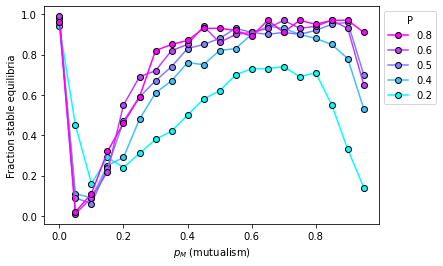

In [187]:
df.plot(marker='o', cmap='cool', mec='k')
handles, labels = plt.gca().get_legend_handles_labels()
order = list(range(len(labels)))[::-1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          title = "P", loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("$p_M$ (mutualism)")
plt.ylabel("Fraction stable equilibria")